In [21]:
import numpy as np
import pandas as pd

In [22]:
# import image processing libs
import matplotlib.pyplot as plt
from PIL import Image
import os

In [23]:
# define dataset path
dataset_path = 'dataset'

In [24]:
spiral_images = f'{dataset_path}/spiral'
wave_images = f'{dataset_path}/wave'

print(f"Spiral images path: {spiral_images}")
print(f"Wave images path: {wave_images}")

Spiral images path: dataset/spiral
Wave images path: dataset/wave


In [25]:
# Define paths for training data - COMBINED spiral and wave
spiral_training_path = f'{spiral_images}/training'
spiral_testing_path = f'{spiral_images}/testing'

wave_training_path = f'{wave_images}/training'
wave_testing_path = f'{wave_images}/testing'

print(f"Spiral training path: {spiral_training_path}")
print(f"Spiral testing path: {spiral_testing_path}")
print(f"Wave training path: {wave_training_path}")
print(f"Wave testing path: {wave_testing_path}")

Spiral training path: dataset/spiral/training
Spiral testing path: dataset/spiral/testing
Wave training path: dataset/wave/training
Wave testing path: dataset/wave/testing


### Data View

Loading an image from both healthy and parkinson's folders will help qualitatively analyse the structural differences between both of these cases

### Data Preprocessing

Setting up image preprocessing pipeline:
- Convert images to grayscale (256x256x1)
- Normalize pixel values to [0, 1]
- Apply data augmentation for training (rotation, shift, zoom, flip)
- No augmentation for testing data

In [26]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
# Create ImageDataGenerator with MUCH stronger augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,          # Increased
    width_shift_range=0.3,      # Increased
    height_shift_range=0.3,     # Increased
    shear_range=0.3,            # Increased
    zoom_range=0.3,             # Increased
    horizontal_flip=True,
    vertical_flip=True,         # Added
    brightness_range=[0.7, 1.3], # Added
    fill_mode="nearest",
)

# no augmentation on testing dataset
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

print("Strong data augmentation enabled for small dataset (72 samples)")

Strong data augmentation enabled for small dataset (72 samples)


In [28]:
IMG_HEIGHT = 224  # Changed from 256 for MobileNetV2
IMG_WIDTH = 224
BATCH_SIZE = 16
COLOR_MODE = 'rgb'  # Changed from grayscale - MobileNetV2 expects RGB

In [29]:
# Load SPIRAL training data
spiral_train_generator = train_datagen.flow_from_directory(
    spiral_training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

# Load SPIRAL testing data
spiral_test_generator = test_datagen.flow_from_directory(
    spiral_testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Load WAVE training data
wave_train_generator = train_datagen.flow_from_directory(
    wave_training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

# Load WAVE testing data
wave_test_generator = test_datagen.flow_from_directory(
    wave_testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

print(f"\nSPIRAL Dataset:")
print(f"  Class indices: {spiral_train_generator.class_indices}")
print(f"  Training samples: {spiral_train_generator.samples}")
print(f"  Testing samples: {spiral_test_generator.samples}")

print(f"\nWAVE Dataset:")
print(f"  Class indices: {wave_train_generator.class_indices}")
print(f"  Training samples: {wave_train_generator.samples}")
print(f"  Testing samples: {wave_test_generator.samples}")

print(f"\nTOTAL:")
print(f"  Training samples: {spiral_train_generator.samples + wave_train_generator.samples}")
print(f"  Testing samples: {spiral_test_generator.samples + wave_test_generator.samples}")

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.

SPIRAL Dataset:
  Class indices: {'healthy': 0, 'parkinson': 1}
  Training samples: 72
  Testing samples: 30

WAVE Dataset:
  Class indices: {'healthy': 0, 'parkinson': 1}
  Training samples: 72
  Testing samples: 30

TOTAL:
  Training samples: 144
  Testing samples: 60


In [30]:
# Create combined generators that alternate between spiral and wave
def combined_generator(gen1, gen2):
    """Combine two generators by alternating batches"""
    while True:
        # Get batch from spiral
        X1, y1 = next(gen1)
        yield X1, y1
        
        # Get batch from wave
        X2, y2 = next(gen2)
        yield X2, y2

# Create combined training and testing generators
train_generator = combined_generator(spiral_train_generator, wave_train_generator)
test_generator = combined_generator(spiral_test_generator, wave_test_generator)

# Calculate steps per epoch
total_train_samples = spiral_train_generator.samples + wave_train_generator.samples
total_test_samples = spiral_test_generator.samples + wave_test_generator.samples

steps_per_epoch = total_train_samples // BATCH_SIZE
validation_steps = total_test_samples // BATCH_SIZE

print(f"\nCombined generators created!")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Combined generators created!
Steps per epoch: 9
Validation steps: 3


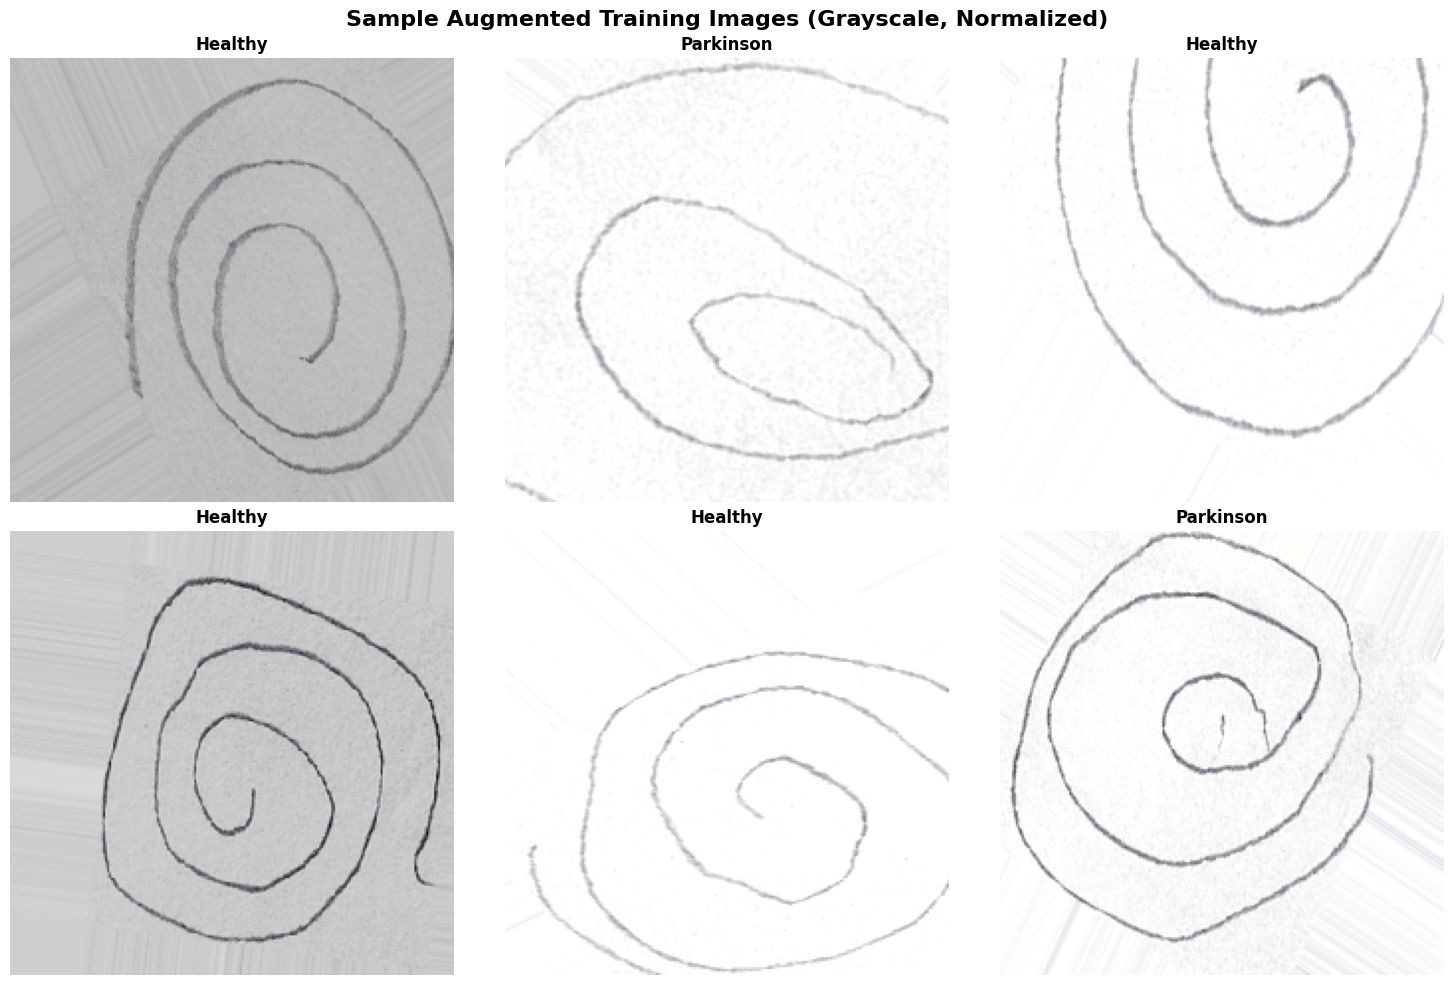


Image shape after preprocessing: (224, 224, 3)
Pixel value range: [0.325, 0.792]


In [31]:
# Visualize some augmented training images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Get a batch of training images
sample_batch = next(train_generator)
sample_images = sample_batch[0]  # Images
sample_labels = sample_batch[1]  # Labels

class_names = {0: 'Healthy', 1: 'Parkinson'}

for i in range(6):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    label = int(sample_labels[i])
    axes[i].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Augmented Training Images (Grayscale, Normalized)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nImage shape after preprocessing: {sample_images[0].shape}")
print(f"Pixel value range: [{sample_images[0].min():.3f}, {sample_images[0].max():.3f}]")

### Build CNN Model

Creating a Convolutional Neural Network optimized for **high recall** to minimize false negatives (missing Parkinson's cases)

In [32]:
# Import necessary layers and models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

In [33]:
# Build model using Transfer Learning with MobileNetV2
# Pre-trained on ImageNet, fine-tuned for Parkinson's detection

# Load pre-trained MobileNetV2 (without top classification layer)
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers initially
base_model.trainable = False

# Build custom classification head
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name='parkinson_mobilenet')

print("Transfer Learning model created with MobileNetV2!")
print(f"Base model trainable: {base_model.trainable}")
model.summary()

Transfer Learning model created with MobileNetV2!
Base model trainable: False
Model: "parkinson_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                   

In [34]:
# Compile with HIGHER learning rate for faster learning
from tensorflow.keras.metrics import Recall, Precision

model.compile(
    optimizer=Adam(learning_rate=0.001),  # 10x higher
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001) - HIGH for small dataset")
print(f"Loss: Binary Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")

Model compiled successfully!
Optimizer: Adam (lr=0.001) - HIGH for small dataset
Loss: Binary Crossentropy
Metrics: Accuracy, Precision, Recall


In [35]:
# Setup callbacks with longer patience
callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=30,  # Much longer patience
        verbose=1,
        restore_best_weights=True
    ),
    
    ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

print("Callbacks configured with extended patience for small dataset")

Callbacks configured with extended patience for small dataset


In [36]:
# Train the model on combined spiral + wave dataset
EPOCHS = 50

print(f"Starting training for {EPOCHS} epochs...")
print(f"Total training samples: {total_train_samples} (Spiral + Wave)")
print(f"Total testing samples: {total_test_samples} (Spiral + Wave)")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print("-" * 60)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)

Starting training for 50 epochs...
Total training samples: 144 (Spiral + Wave)
Total testing samples: 60 (Spiral + Wave)
Steps per epoch: 9
Validation steps: 3
------------------------------------------------------------
Epoch 1/50


2025-12-06 02:31:04.817151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


8/9 [=========================>....] - ETA: 0s - loss: 1.3653 - accuracy: 0.5333 - precision: 0.5645 - recall: 0.5469
Epoch 1: val_accuracy improved from -inf to 0.71739, saving model to best_model.keras
9/9 [==============================] - 3s 242ms/step - loss: 1.3472 - accuracy: 0.5469 - precision: 0.5672 - recall: 0.5672 - val_loss: 0.5747 - val_accuracy: 0.7174 - val_precision: 1.0000 - val_recall: 0.1875 - lr: 0.0010
Epoch 2/50
8/9 [=========================>....] - ETA: 0s - loss: 1.6838 - accuracy: 0.4531 - precision: 0.4348 - recall: 0.3125
Epoch 2: val_accuracy did not improve from 0.71739
9/9 [==============================] - 1s 64ms/step - loss: 1.7118 - accuracy: 0.4559 - precision: 0.4400 - recall: 0.3235 - val_loss: 1.6072 - val_accuracy: 0.3864 - val_precision: 1.0000 - val_recall: 0.0690 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.5296 - accuracy: 0.5368 - precision: 0.5542 - recall: 0.6389
Epoch 3: val_accuracy did not improve fr

### Model Evaluation on Test Set

Evaluating the trained model on test images to assess performance

In [37]:
# Evaluate the model on combined test data
print("Evaluating model on combined test set (Spiral + Wave)...")
print("-" * 60)

# Create a fresh test generator for evaluation
combined_test_gen = combined_generator(spiral_test_generator, wave_test_generator)

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    combined_test_gen,
    steps=validation_steps,
    verbose=1
)

print("\n" + "=" * 60)
print("TEST SET RESULTS (Spiral + Wave Combined)")
print("=" * 60)
print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

# Calculate F1-score for balance check
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
print(f"F1-Score:  {f1_score:.4f} ({f1_score*100:.2f}%)")
print("=" * 60)

# Interpretation
if test_recall > 0.95 and test_precision < 0.6:
    print("\n⚠ WARNING: High recall but low precision → predicting too many positives")
elif test_recall < 0.3:
    print("\n⚠ WARNING: Low recall → missing too many Parkinson's cases")
else:
    print("\n✓ Model shows balanced performance")

Evaluating model on combined test set (Spiral + Wave)...
------------------------------------------------------------
3/3 [==============================] - 0s 36ms/step - loss: 0.5211 - accuracy: 0.7727 - precision: 0.9524 - recall: 0.6897

TEST SET RESULTS (Spiral + Wave Combined)
Loss:      0.5211
Accuracy:  0.7727 (77.27%)
Precision: 0.9524 (95.24%)
Recall:    0.6897 (68.97%)
F1-Score:  0.8000 (80.00%)

✓ Model shows balanced performance


In [38]:
# Diagnostic: Check prediction distribution on combined test set
import numpy as np

# Collect all test data and predictions
print("Collecting test data from both spiral and wave datasets...")

# Reset individual generators
spiral_test_generator.reset()
wave_test_generator.reset()

# Collect spiral test data
spiral_images = []
spiral_labels = []
for i in range(len(spiral_test_generator)):
    X, y = next(spiral_test_generator)
    spiral_images.append(X)
    spiral_labels.append(y)
spiral_images = np.vstack(spiral_images)
spiral_labels = np.concatenate(spiral_labels)

# Collect wave test data
wave_images = []
wave_labels = []
for i in range(len(wave_test_generator)):
    X, y = next(wave_test_generator)
    wave_images.append(X)
    wave_labels.append(y)
wave_images = np.vstack(wave_images)
wave_labels = np.concatenate(wave_labels)

# Combine all test data
all_test_images = np.vstack([spiral_images, wave_images])
all_test_labels = np.concatenate([spiral_labels, wave_labels])

# Get predictions
y_pred_prob = model.predict(all_test_images, verbose=0)
y_true = all_test_labels

print("=" * 60)
print("PREDICTION DISTRIBUTION ANALYSIS (Spiral + Wave)")
print("=" * 60)
print(f"Total test samples: {len(y_true)}")
print(f"\nPrediction probabilities (for Parkinson's class):")
print(f"  Min:    {y_pred_prob.min():.4f}")
print(f"  Max:    {y_pred_prob.max():.4f}")
print(f"  Mean:   {y_pred_prob.mean():.4f}")
print(f"  Median: {np.median(y_pred_prob):.4f}")

# Show distribution by true class
healthy_probs = y_pred_prob[y_true == 0]
parkinson_probs = y_pred_prob[y_true == 1]

print(f"\nFor TRUE Healthy cases (should be LOW):")
print(f"  Mean probability: {healthy_probs.mean():.4f}")
print(f"  Range: [{healthy_probs.min():.4f}, {healthy_probs.max():.4f}]")

print(f"\nFor TRUE Parkinson cases (should be HIGH):")
print(f"  Mean probability: {parkinson_probs.mean():.4f}")
print(f"  Range: [{parkinson_probs.min():.4f}, {parkinson_probs.max():.4f}]")

# Count predictions at different thresholds
print(f"\nPredictions at different thresholds:")
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    count = np.sum(y_pred_prob > thresh)
    print(f"  Threshold {thresh}: {count}/{len(y_true)} predicted as Parkinson's")
    
print("=" * 60)

PREDICTION DISTRIBUTION ANALYSIS (Spiral + Wave)
Total test samples: 60

Prediction probabilities (for Parkinson's class):
  Min:    0.0394
  Max:    0.9888
  Mean:   0.4149
  Median: 0.2830

For TRUE Healthy cases (should be LOW):
  Mean probability: 0.1913
  Range: [0.0394, 0.5515]

For TRUE Parkinson cases (should be HIGH):
  Mean probability: 0.6384
  Range: [0.0860, 0.9888]

Predictions at different thresholds:
  Threshold 0.3: 29/60 predicted as Parkinson's
  Threshold 0.4: 22/60 predicted as Parkinson's
  Threshold 0.5: 21/60 predicted as Parkinson's
  Threshold 0.6: 20/60 predicted as Parkinson's
  Threshold 0.7: 18/60 predicted as Parkinson's


Generating predictions on combined test set...

Using decision threshold: 0.5
Total test samples: 60 (Spiral + Wave)
------------------------------------------------------------


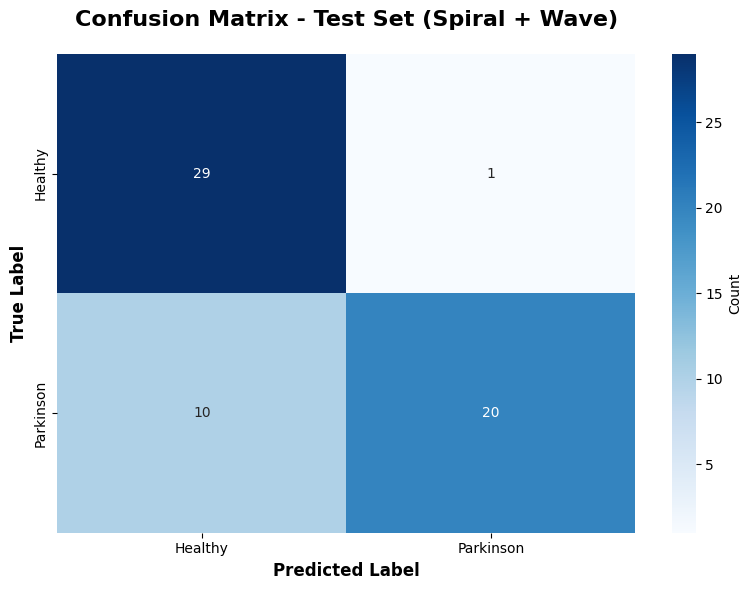


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Healthy       0.74      0.97      0.84        30
   Parkinson       0.95      0.67      0.78        30

    accuracy                           0.82        60
   macro avg       0.85      0.82      0.81        60
weighted avg       0.85      0.82      0.81        60


Confusion Matrix Breakdown:
  True Negatives (Healthy correctly identified):  29
  False Positives (Healthy misclassified):        1
  False Negatives (Parkinson missed):             10
  True Positives (Parkinson correctly identified): 20

Metrics:
  Precision: 0.95 (95.2%)
  Recall: 0.67 (66.7%)
  F1-Score: 0.78 (78.4%)


In [39]:
# Generate predictions and confusion matrix on combined dataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Use the collected test data from diagnostic cell
print("Generating predictions on combined test set...")

# Use standard threshold of 0.5
THRESHOLD = 0.5
y_pred = (y_pred_prob > THRESHOLD).astype(int).flatten()

print(f"\nUsing decision threshold: {THRESHOLD}")
print(f"Total test samples: {len(y_true)} (Spiral + Wave)")
print("-" * 60)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Parkinson'],
            yticklabels=['Healthy', 'Parkinson'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Test Set (Spiral + Wave)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Parkinson'], zero_division=0))

# Calculate and display confusion matrix metrics
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Healthy correctly identified):  {tn}")
print(f"  False Positives (Healthy misclassified):        {fp}")
print(f"  False Negatives (Parkinson missed):             {fn}")
print(f"  True Positives (Parkinson correctly identified): {tp}")

# Calculate metrics manually
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nMetrics:")
print(f"  Precision: {precision:.2f} ({precision*100:.1f}%)")
print(f"  Recall: {recall:.2f} ({recall*100:.1f}%)")
print(f"  F1-Score: {f1:.2f} ({f1*100:.1f}%)")
print("=" * 60)

/var/folders/9s/ph30m8t55gx79ctymxtfv5f80000gn/T/ipykernel_22155/2410893737.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(predictions[i] > 0.5)


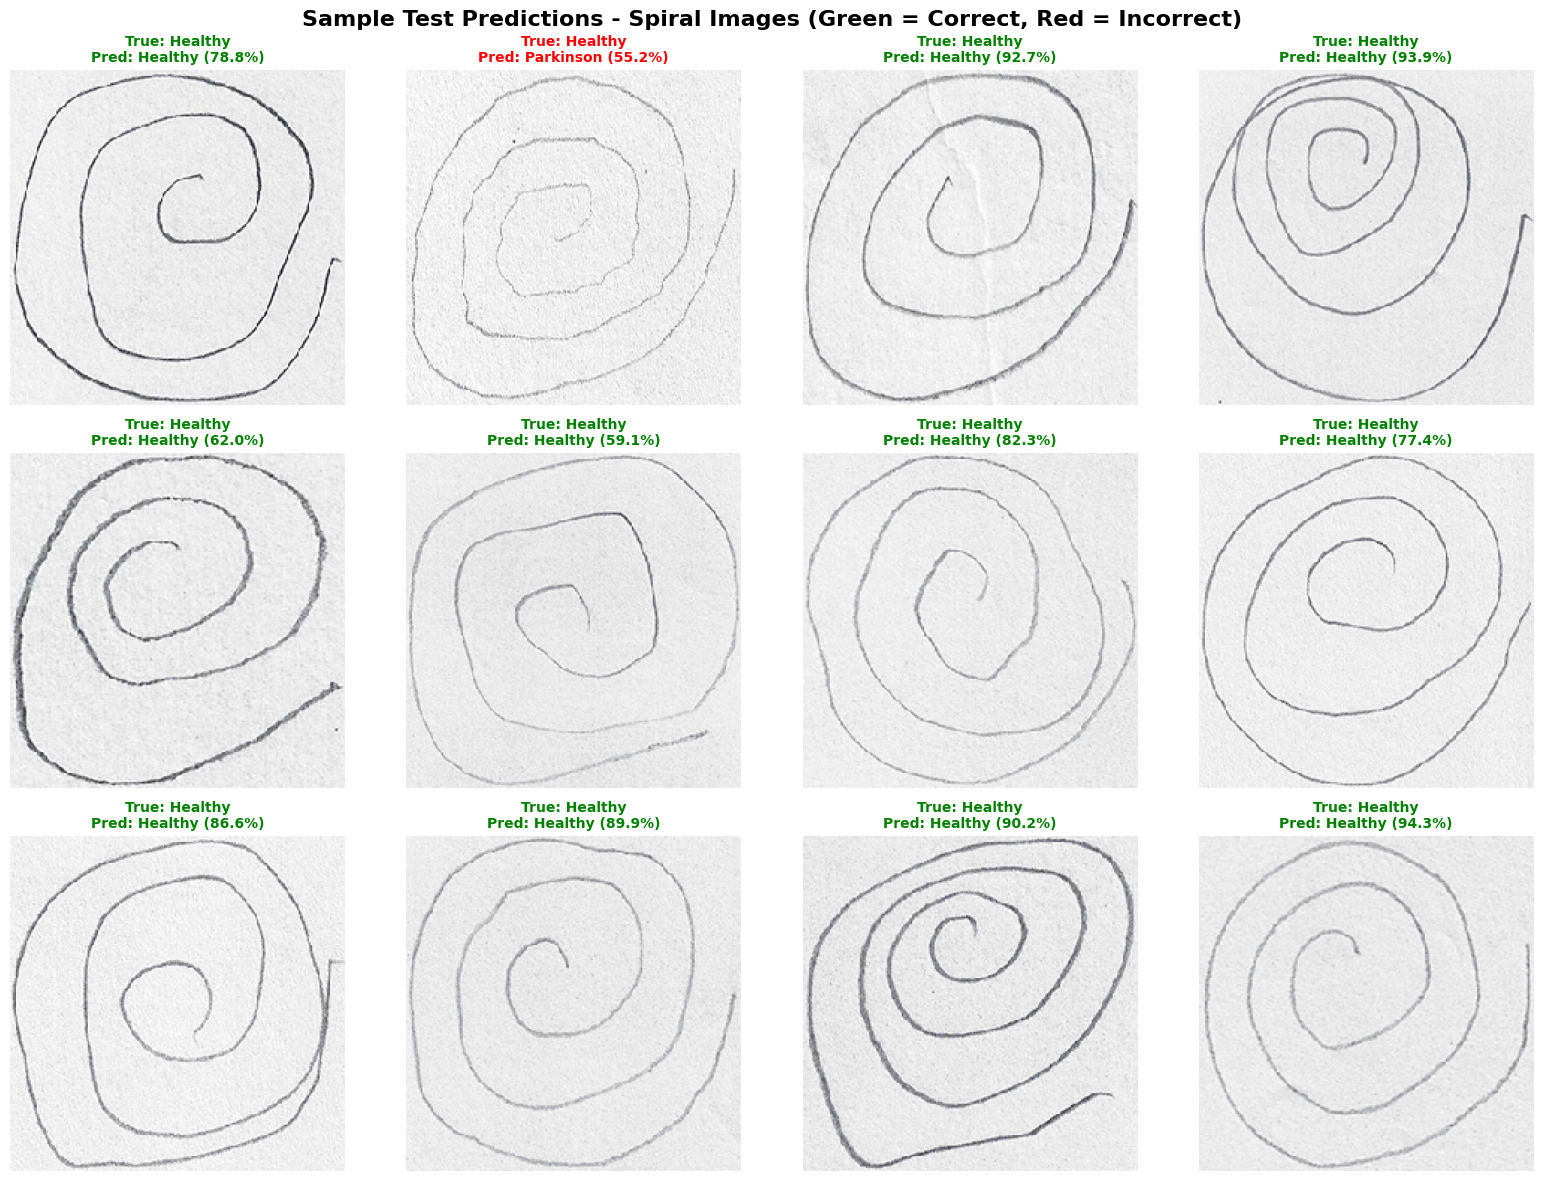

In [40]:
# Visualize sample predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

# Get test images from spiral generator
spiral_test_generator.reset()
test_images, test_labels = next(spiral_test_generator)

# Get predictions for this batch
predictions = model.predict(test_images, verbose=0)

class_names = {0: 'Healthy', 1: 'Parkinson'}

for i in range(12):
    if i < len(test_images):
        # Display image (handle RGB by taking first channel if grayscale was expected)
        if test_images[i].shape[-1] == 3:
            axes[i].imshow(test_images[i])
        else:
            axes[i].imshow(test_images[i].squeeze(), cmap='gray')
        
        true_label = int(test_labels[i])
        pred_label = int(predictions[i] > 0.5)
        confidence = predictions[i][0] if pred_label == 1 else 1 - predictions[i][0]
        
        # Color code: green for correct, red for incorrect
        color = 'green' if true_label == pred_label else 'red'
        
        title = f'True: {class_names[true_label]}\n'
        title += f'Pred: {class_names[pred_label]} ({confidence*100:.1f}%)'
        
        axes[i].set_title(title, fontsize=10, fontweight='bold', color=color)
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.suptitle('Sample Test Predictions - Spiral Images (Green = Correct, Red = Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()